**Multivariate Time Series Forecasting with LSTMs in Keras**
by Jason Brownlee 

Forecasting a Time series

This notebook shows how to prepare a time series dataset for forecasting using any machine learning or neural network approach.
The dataset pollution is used and contains 8 variables, the output being the pm10 concentrations.

The first section shows how to predict the output variable using one timestep lag of each of the other variables.

The second section shows how to predict the output variable using more than one timestep lag of each of the other variables.



#TODO
Forecast several points ahead


In [1]:
#Download Data File from your local disc to  collab directory
from google.colab import files
uploaded = files.upload()


Saving pollution.txt to pollution.txt


In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

The script below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

In [3]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('pollution.txt',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

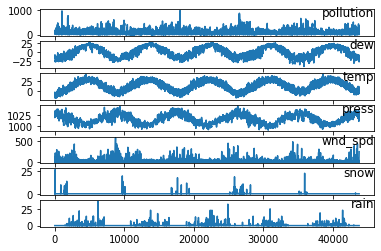

In [4]:
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

** Multivariate LSTM Forecast Model**

---

LSTM Data Preparation

---


The first step is to prepare the pollution dataset for the LSTM.

---

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

We can transform the dataset using the series_to_supervised() function developed in the blog post:
[How to Convert a Time Series to a Supervised Learning Problem in Python](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

First, the “pollution.csv” dataset is loaded. The wind dircetion feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


**TODO**
This data preparation is simple and there is more we could explore. Some ideas you could look at include:


1.   One-hot encoding wind speed.
2.   Making all series stationary with differencing and seasonal adjustment.
3.   Providing more than 1 hour of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

**Define and Fit Model**

In this section, we will fit an LSTM on the multivariate input data.

To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. 
The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [7]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8)
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

Epoch 1/50
122/122 - 8s - loss: 0.0587 - val_loss: 0.0473 - 8s/epoch - 63ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0379 - val_loss: 0.0440 - 2s/epoch - 14ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0208 - val_loss: 0.0390 - 2s/epoch - 14ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0164 - val_loss: 0.0250 - 2s/epoch - 15ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0151 - val_loss: 0.0184 - 2s/epoch - 15ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0150 - val_loss: 0.0170 - 2s/epoch - 15ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0170 - 2s/epoch - 15ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0157 - 2s/epoch - 14ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0148 - val_loss: 0.0158 - 2s/epoch - 15ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0148 - val_loss: 0.0150 - 2s/epoch - 15ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0147 - val_loss: 0.0144 - 2s/epoch - 14ms/step
Epoch 12/50
122/122 - 2s - loss: 0.0146 - val_loss: 0.0143 - 2s/epoch - 15ms/step
Epoch 13/50
122/122 - 2s 

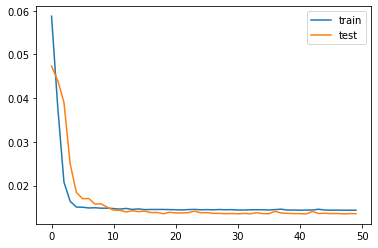

In [8]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Evaluate Model**

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate the RMSE for the model. 

In [9]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(35039, 1, 8)
Test RMSE: 26.613


**TODO**
This model is not tuned. Can you do better?

**Update: Train On Multiple Lag Timesteps Example**

---

The changes needed to train the model on multiple previous time steps are quite minimal, as follows:

First, you must frame the problem suitably when calling series_to_supervised(). We will use 3 hours of data as input. Also note, we no longer explictly drop the columns from all of the other fields at ob(t).

Next, we need to be more careful in specifying the column for input and output.

We have 3 * 8 + 8 columns in our framed dataset. We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour, as follows:

Next, we can reshape our input data correctly to reflect the time steps and features.

Fitting the model is the same.

The only other small change is in how to evaluate the model. Specifically, in how we reconstruct the rows with 8 columns suitable for reversing the scaling operation to get the y and yhat back into the original scale so that we can calculate the RMSE.

The gist of the change is that we concatenate the y or yhat column with the last 7 features of the test dataset in order to inverse the scaling, as follows:

(43797, 32)
trainX,gtX (8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 4s - loss: 0.0471 - val_loss: 0.0471 - 4s/epoch - 36ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0250 - val_loss: 0.0332 - 2s/epoch - 15ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0210 - val_loss: 0.0214 - 2s/epoch - 15ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0208 - val_loss: 0.0205 - 2s/epoch - 15ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0206 - val_loss: 0.0197 - 2s/epoch - 15ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0200 - val_loss: 0.0186 - 2s/epoch - 14ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0196 - val_loss: 0.0182 - 2s/epoch - 14ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0192 - val_loss: 0.0178 - 2s/epoch - 15ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0187 - val_loss: 0.0175 - 2s/epoch - 15ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0183 - val_loss: 0.0170 - 2s/epoch - 15ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0179 - val_loss: 0.0167 - 2s/epoch - 14ms/step
Epoch 12/50
122/

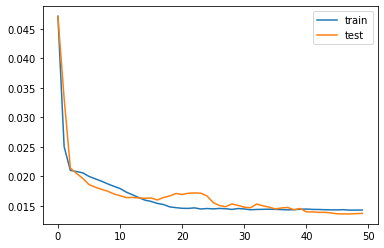

Test RMSE: 26.391


In [10]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print('trainX,gtX',train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)